# Importing necessary libraries
# reading data
# Analysing data(any duplicates, null values, types of columns,etc)
# Data cleaning - check for null values and handle them
# Preprocessing/feature engineering - converted "date_of_journey" to datetime and seperated into day month columns
# - Convert duration to hours and minutes columns
# Transformation- Encoding total stops
# -encoding dep_hour, dep_min, Arr_hour, arr_min and dropping original dep_time and arr_time
# drop route column as num of stops column created
# Merging Delhi and New Delhi
# #One-hot encode categorical columns 'Airline', 'Source', 'Destination'
# Check correlation of dummies with target
# columns dropped as they have very poor effect on price
# cleaned data saved
# Eda # Check if Price is skewed,#price and total stops correlation, creelation with all other features,check for outliers in price
# Model training
# training 5 models - LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,XGBRegressor
# finding the MAE, RMSE, and R2 scores for all the models

# Scatter plot for linearity check
# checking feature importance

# creating Mlflow for logging in the experiments and models
# Training  5 models and logging into mlflow 
# hyperparametr tuning for XGBRegressor--as best results were obtained under this model
# manually checking with the best params obtained by tuning

# check for tuning RandomForestRegressor
# check for tuning GradientBoostingRegressor
# registered the XGBRegressor as it gave best results

In [ ]:
# 1:Importing libraries required for Flight Price Prediction.

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split

In [270]:
#2: Reading data.
df=pd.read_csv('Flight_Price.csv')
df

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU ? BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU ? BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR ? DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR ? DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [274]:
df['Source'].value_counts()

Source
Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: count, dtype: int64

In [ ]:
#3: Analysing data(any duplicates, null values, types of columns,etc)
df.columns
df.isnull().sum()
df.describe()
df.info()
df.dtypes
df.duplicated().sum()

In [ ]:
duplicates = df[df.duplicated(keep=False)]
print(duplicates)

In [ ]:
# 4:check for null values and handle them
df.isnull().sum()
df.dropna(inplace=True)

In [ ]:
# 5:convert Date_of_Journey column to day month and year Datetime columns.
df['Day'] = pd.to_datetime(df['Date_of_Journey'],format='%d/%m/%Y').dt.day
df['Month'] = pd.to_datetime(df['Date_of_Journey'],format='%d/%m/%Y').dt.month
#df['Year'] = pd.to_datetime(df['Date_of_Journey'],format='%d/%m/%Y').dt.year
df.drop('Date_of_Journey',inplace=True,axis=1)


In [ ]:
#6:convert duration to hours and minutes columns
df['Duration_hours']=df['Duration'].str.extract(r'(\d+)h').fillna(0).astype(int)
df['Duration_mins']=df['Duration'].str.extract(r'(\d+)m').fillna(0).astype(int)
df.drop(['Duration'],axis=1,inplace=True)

In [ ]:
df['Total_Stops'].value_counts()

In [ ]:
# Encoding total stops
df['Total_Stops']=df['Total_Stops'].map({"non-stop":0,"1 stop":1,"2 stops":2,"3 stops":3,"4 stops":4})

In [ ]:
# encoding dep_hour, dep_min, Arr_hour, arr_min and dropping original dep_time and arr_time
df['Dep_hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
df['Dep_min'] = pd.to_datetime(df['Dep_Time']).dt.minute
df.drop('Dep_Time',axis=1,inplace=True)

df['Arrival_hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
df['Arrival_min'] = pd.to_datetime(df['Arrival_Time']).dt.minute
df.drop('Arrival_Time',axis=1,inplace=True)


In [ ]:
#drop route column as num of stops column created
df.drop(['Route'],inplace=True,axis=1)

In [ ]:
df['Destination'].value_counts()

In [ ]:
#converting New-delhi to one single column Delhi in source and destination
def newdelhi_to_delhi(x):
    if x=='New Delhi':
        return 'Delhi'
    else:
        return x

df['Destination'] = df['Destination'].apply(newdelhi_to_delhi)
df['Source'] = df['Source'].apply(newdelhi_to_delhi)
#OR
# Clean city names
'''df['Source'] = df['Source'].replace({'New Delhi': 'Delhi'})
df['Destination'] = df['Destination'].replace({'New Delhi': 'Delhi'})'''

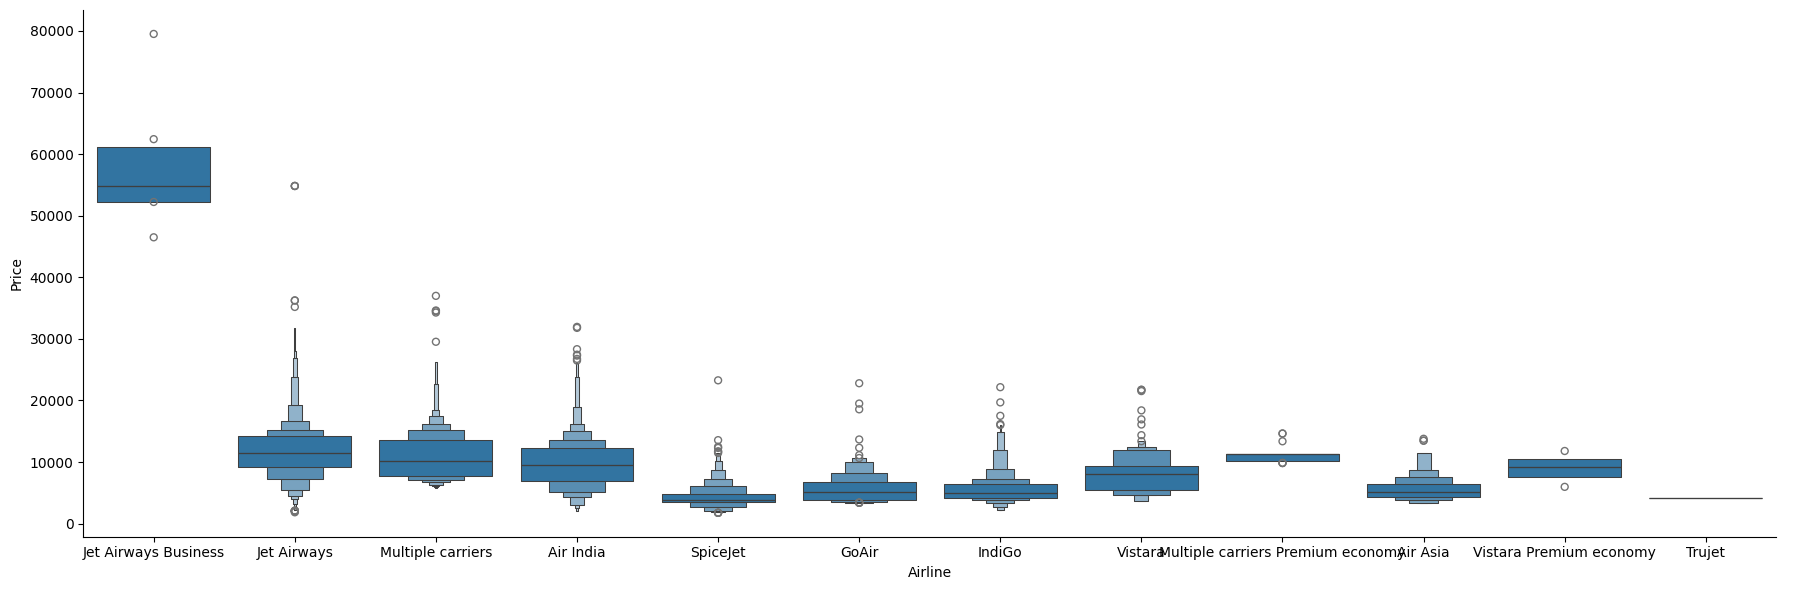

In [275]:
#some EDA
import seaborn as sns
# we can observe that jet airways bussiness is he costliest airways
sns.catplot(x='Airline',y='Price',data=df.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=6)

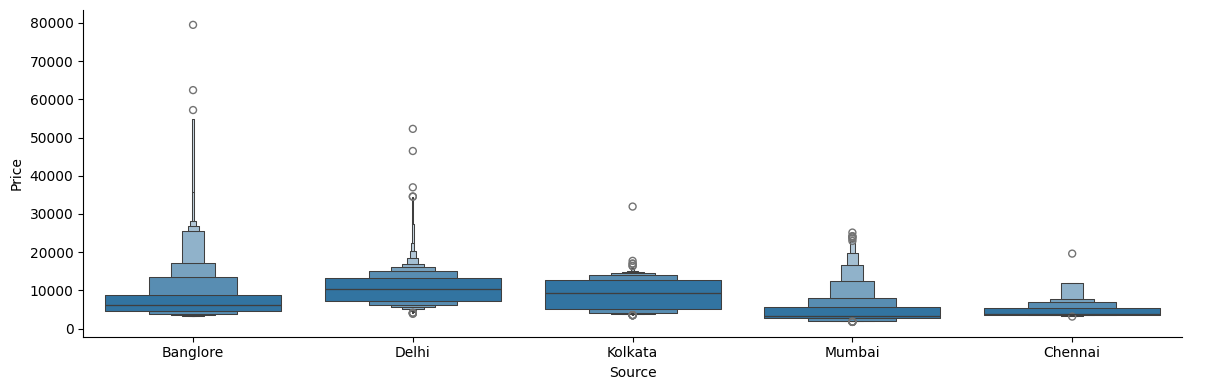

In [ ]:
#  checking the prices fro different sources(cities)
sns.catplot(x='Source',y='Price',data=df.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

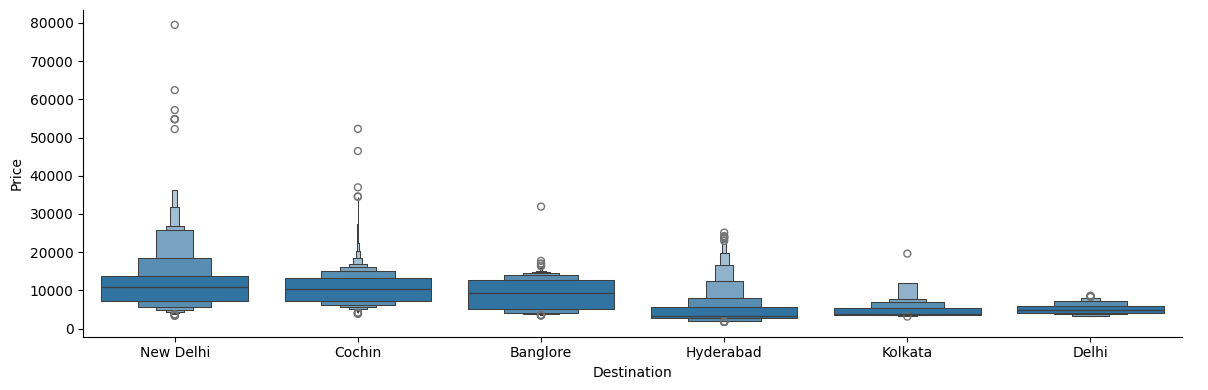

In [277]:
# If we are going to New Delhi(destination) the prices are slightly higher as compared to other cities
sns.catplot(x='Destination',y='Price',data=df.sort_values('Price',ascending=False),kind='boxen',aspect=3,height=4)

In [ ]:
#One-hot encode categorical columns
df = pd.get_dummies(df, columns=['Airline', 'Source', 'Destination'], drop_first=True,dtype=int)

In [ ]:
df['Additional_Info'].value_counts()

In [ ]:
#ohe for Additiona_info
df = pd.get_dummies(df, columns=['Additional_Info'], drop_first=True,dtype=int)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check correlation of dummies with target
correlations = df.corr()['Price'].sort_values(ascending=False)
print(correlations.filter(like='Additional_Info'))

In [ ]:
#check correlation of price with all columns
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = df.corr()

# Focus only on features vs. 'Price'
price_correlations = correlation_matrix[['Price']].sort_values(by='Price', ascending=False)

# Plot the heatmap
plt.figure(figsize=(6, len(price_correlations) * 0.3))  # Dynamic height
sns.heatmap(price_correlations, annot=True, cmap='coolwarm', center=0)

plt.title('Correlation of All Features with Price', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# List of columns to drop as they have very poor effect on price
columns_to_drop = [
    'Additional_Info_No Info',
    'Additional_Info_Red-eye flight',
    'Additional_Info_No info',
    'Additional_Info_1 Short layover',                 
    'Additional_Info_2 Long layover'   
]

# Dropping the selected columns
df.drop(columns=columns_to_drop, inplace=True)

# Verify the changes
print(df.head())

In [ ]:
columns_of_interest = ['Additional_Info_In-flight meal not included',
    
    'Additional_Info_Business class',
    'Additional_Info_Change airports',
    
    'Additional_Info_No check-in baggage included'
]

for col in columns_of_interest:
    print(f"\nValue counts for '{col}':")
    print(df[col].value_counts())

In [ ]:
#cleaned and transformed data
df

In [268]:
df_cleaned = df.copy()  # If df is your original DataFrame and you want to keep a cleaned copy

# Save the cleaned DataFrame to a CSV file
df_cleaned.to_csv("cleaned_Flight_Price.csv", index=False)


In [269]:
df_cleaned

,Total_Stops,Price,Day,Month,Duration_hours,Duration_mins,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No check-in baggage included
0,0,3897,24,3,2,50,22,20,1,10,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2,7662,1,5,7,25,5,50,13,15,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,2,13882,9,6,19,0,9,25,4,25,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,1,6218,12,5,5,25,18,5,23,30,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1,13302,1,3,4,45,16,50,21,35,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,0,4107,9,4,2,30,19,55,22,25,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
10679,0,4145,27,4,2,35,20,45,23,20,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
10680,0,7229,27,4,3,0,8,20,11,20,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
10681,0,12648,1,3,2,40,11,30,14,10,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


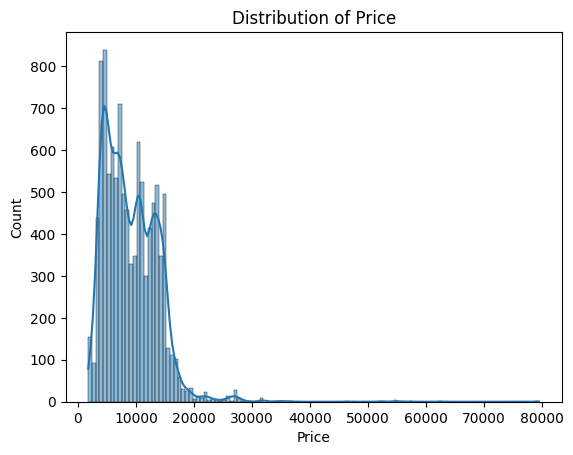

In [280]:
# Check if Price is skewed
sns.histplot(df['Price'], kde=True)
plt.title('Distribution of Price')
plt.show()

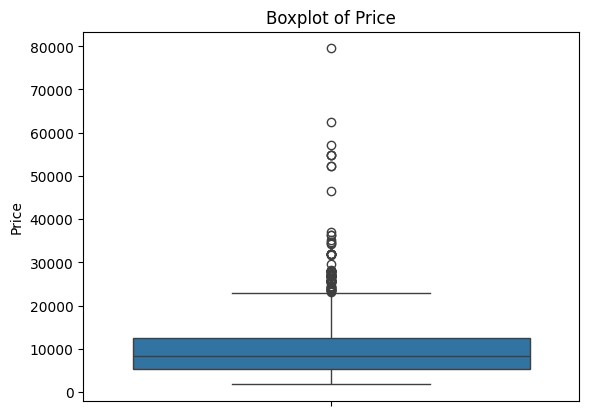

In [283]:
#checking for outliers in price
sns.boxplot(df['Price'])
plt.title('Boxplot of Price')
plt.show()

In [ ]:
# ------------------------
# EDA: Correlation of price with other features
# ------------------------
plt.figure(figsize=(10, 6))
corr = df.corr(numeric_only=True)['Price'].sort_values()
corr.drop('Price').plot(kind='barh', color='steelblue')
plt.title('Correlation with Price')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

In [ ]:
#Preparing for model training
from sklearn.model_selection import train_test_split

X = df.drop('Price', axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# training 5 models - LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,XGBRegressor
# finding the MAE, RMSE, and R2 scores for all the models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Decision Tree Regressor':DecisionTreeRegressor(random_state=42),
    'XGB Regressor':XGBRegressor(random_state=42, n_estimators=100),
    'Gradient Boosting Regressor':GradientBoostingRegressor(random_state=42, n_estimators=100)

}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Performance:")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R² Score:", r2_score(y_test, y_pred))
    print("-" * 40)


Linear Regression Performance:
MAE: 1823.5030670580718
RMSE: 2693.8164401955805
R² Score: 0.6634529237669966
----------------------------------------
Random Forest Performance:
MAE: 646.9006573523185
RMSE: 1647.2293947503513
R² Score: 0.8741602081852882
----------------------------------------
Decision Tree Regressor Performance:
MAE: 670.754094525035
RMSE: 1816.1185545935311
R² Score: 0.8470328360731098
----------------------------------------
XGB Regressor Performance:
MAE: 742.9766235351562
RMSE: 1373.4730612574824
R² Score: 0.9125116467475891
----------------------------------------
Gradient Boosting Regressor Performance:
MAE: 1216.1626368745922
RMSE: 1841.4747657760104
R² Score: 0.842731636444622
----------------------------------------


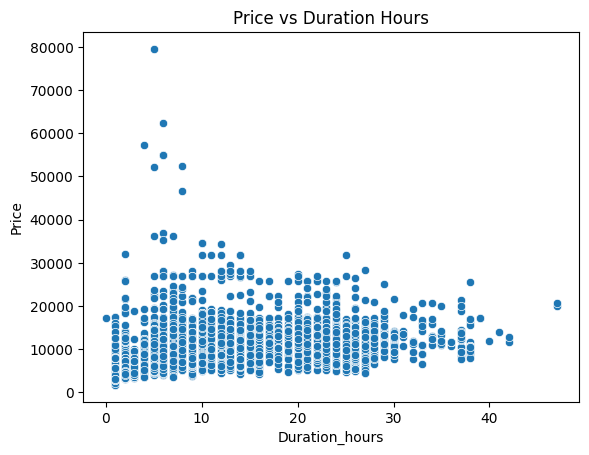

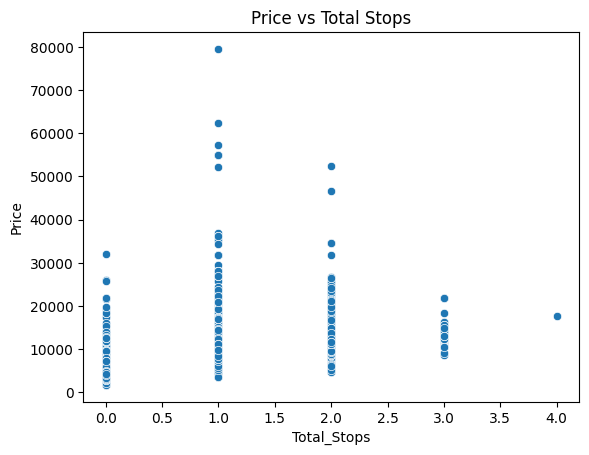

In [ ]:
# Scatter plot for linearity check
sns.scatterplot(x='Duration_hours', y='Price', data=df)
plt.title('Price vs Duration Hours')
plt.show()

sns.scatterplot(x='Total_Stops', y='Price', data=df)
plt.title('Price vs Total Stops')
plt.show()

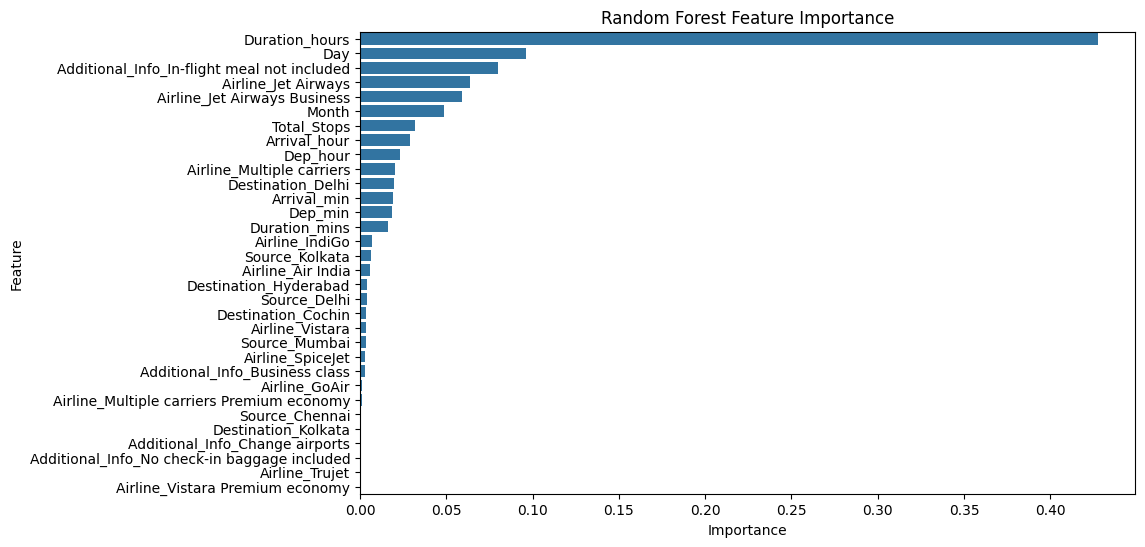

In [ ]:
# checking feature importance
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for easy plotting
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Random Forest Feature Importance')
plt.show()

In [ ]:
#creating Mlflow for logging in the experiments and models
import mlflow
import mlflow.sklearn

In [256]:
mlflow.set_experiment("Flight_price_pred")
mlflow.set_tracking_uri("http://127.0.0.1:5000")

2025/05/01 11:32:48 INFO mlflow.tracking.fluent: Experiment with name 'Flight_price_pred' does not exist. Creating a new experiment.


In [ ]:
#Training  5 models and logging into mlflow 
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Dictionary of models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "Gradient Boosting regressor": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Loop through models and log with MLflow
for model_name, model in models.items():
    with mlflow.start_run(run_name=model_name):
        # Train
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        # Metrics
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)

        # Log metrics
        mlflow.log_metric("MAE", mae)
        mlflow.log_metric("RMSE", rmse)
        mlflow.log_metric("R2", r2)

        # Log model
        if model_name == "XGBoost":
            mlflow.xgboost.log_model(model, "model")
        else:
            mlflow.sklearn.log_model(model, "model")

        print(f"Logged {model_name} with MAE={mae:.2f}, RMSE={rmse:.2f}, R2={r2:.2f}")


In [ ]:
#hyperparametr tuning for XGBRegressor--as best results were obtained under this model
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

xgb_model = XGBRegressor()

param_dist = {
    'n_estimators': [100, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0]
}

random_xgb = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=3, scoring='r2', n_jobs=-1, verbose=1)
random_xgb.fit(X_train, y_train)

print("Best Params:", random_xgb.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Params: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.3}


In [ ]:
#manually checking with the best params obtained by tuning
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators= 300, max_depth =6,learning_rate=0.3,subsample= 0.8)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print(" Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))



 Performance:
MAE: 712.24658203125
RMSE: 1363.265060433957
R² Score: 0.9138073325157166


In [ ]:
#logging in hyperparameter tuning on XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import mlflow
import mlflow.xgboost
from scipy.stats import uniform, randint

# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter space for RandomizedSearchCV
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5)
}

xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Enable MLflow autologging
mlflow.xgboost.autolog()

with mlflow.start_run(run_name="XGBoost_Hyperparameter_Tuning"):
    random_search.fit(X_train, y_train)

    # Best model
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Log metrics manually (optional since autolog logs them too)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("R2", r2)

    print("Best Parameters:", random_search.best_params_)
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")


Fitting 3 folds for each of 25 candidates, totalling 75 fits


2025/05/01 17:39:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\priya\AppData\Roaming\Python\Python39\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/05/01 17:39:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\priya\AppData\Roaming\Python

Best Parameters: {'colsample_bytree': 0.954660201039391, 'learning_rate': 0.08763399448000507, 'max_depth': 10, 'n_estimators': 487, 'subsample': 0.6558555380447055}
MAE: 637.74, RMSE: 1426.73, R2: 0.9056
🏃 View run XGBoost_Hyperparameter_Tuning at: http://127.0.0.1:5000/#/experiments/503638197806967658/runs/c0f7c69a26a14605a13d53ef294b6308
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/503638197806967658


In [ ]:
#logging in manually tuned in params obtained by tuning as that gave the best result
import mlflow
import mlflow.xgboost
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.3,
    subsample=0.8
)
xgb_model.fit(X_train, y_train)

# Enable autologging
mlflow.xgboost.autolog()

with mlflow.start_run(run_name="XGB_Manual_Tuning"):
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    # Manually log metrics (optional)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("R2", r2)

    # register model 
    mlflow.xgboost.log_model(xgb_model, "model", registered_model_name="Best_XGB_Model")

    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

2025/05/01 18:16:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '579f4bd8e4324268b6983e1e0ba82b34', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2025/05/01 18:16:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\priya\AppData\Roaming\Python\Python39\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Mi

🏃 View run zealous-turtle-650 at: http://127.0.0.1:5000/#/experiments/503638197806967658/runs/579f4bd8e4324268b6983e1e0ba82b34
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/503638197806967658


2025/05/01 18:16:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\priya\AppData\Roaming\Python\Python39\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2025/05/01 18:16:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\priya\AppData\Roaming\Python

MAE: 712.25, RMSE: 1363.27, R²: 0.9138
🏃 View run XGB_Manual_Tuning at: http://127.0.0.1:5000/#/experiments/503638197806967658/runs/0cdcd200c006481eb34166c638c68d74
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/503638197806967658


Created version '2' of model 'Best_XGB_Model'.


In [ ]:
#check for tuning RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Best Params:", grid_rf.best_params_)
print("Best R2 Score:", grid_rf.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best R2 Score: 0.8573884295972611


In [ ]:
#check for tuning GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

grid_gbr = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=3, scoring='r2', verbose=1, n_jobs=-1)
grid_gbr.fit(X_train, y_train)
print("Best Params:", grid_gbr.best_params_)
print("Best R2 Score:", grid_gbr.best_score_)
